In [32]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define file paths
file_path_amazon = 'TV_data_Amazon.xlsx'
file_path_bestbuy = 'TV_data_BestBuy.xlsx'
file_path_costco = 'TV_data_costco.xlsx'
file_path_walmart = 'TV_data_walmart.xlsx'

# Load the data
amazon_data = pd.read_excel(file_path_amazon)
bestbuy_data = pd.read_excel(file_path_bestbuy)
costco_data = pd.read_excel(file_path_costco)
walmart_data = pd.read_excel(file_path_walmart)

In [3]:
# ========================== Amazon Data Cleaning ==========================

# Standardize column names
amazon_data.columns = ['Product Name', 'Price', 'Review Mark', 'Review Number']

# Clean the Price column
amazon_data['Discount'] = amazon_data['Price'].str.extract('(\d+)%')[0]
amazon_data['Price'] = amazon_data['Price'].str.extract('(?:-[\d%]+ )?\$([,\d]+\.\d{2})')[0]
amazon_data['Price'] = amazon_data['Price'].replace('[,$]', '', regex=True).astype(float)

# Extract the discount percentage, remove the % sign, and convert to numeric
amazon_data['Discount'] = amazon_data['Discount'].astype(float)

# Extract numbers from Review Number column and convert to numeric
amazon_data['Review Number'] = amazon_data['Review Number'].str.extract('(\d+)')[0].astype(float)

In [4]:
amazon_data.isnull().sum()

Product Name       0
Price             53
Review Mark       40
Review Number     40
Discount         262
dtype: int64

In [7]:
# ========================== BestBuy Data Cleaning ==========================

# Standardize column names
bestbuy_data.columns = ['Product Name', 'Price', 'Reviews']

# Clean the Price column
bestbuy_data['Price'] = bestbuy_data['Price'].replace('[,$]', '', regex=True).astype(float)

# Extract the review mark and review number from the Reviews column and convert to numeric
bestbuy_data['Review Mark'] = bestbuy_data['Reviews'].str.extract('(\d+\.\d+)')[0].astype(float)
bestbuy_data['Review Number'] = bestbuy_data['Reviews'].str.extract('with (\d+) reviews')[0].astype(float)

# Drop the original Reviews column
bestbuy_data = bestbuy_data.drop(columns=['Reviews'])

In [8]:
bestbuy_data.isnull().sum()

Product Name      0
Price             0
Review Mark      97
Review Number    68
dtype: int64

In [10]:
# ========================== Costco Data Cleaning ==========================

# Standardize column names
costco_data.columns = ['Product Name', 'Price', 'Review Mark', 'Review Number']

# Clean the Review Number column
costco_data['Review Number'] = costco_data['Review Number'].abs()


In [11]:
costco_data.isnull().sum()

Product Name      0
Price             1
Review Mark      16
Review Number     0
dtype: int64

In [13]:
# ========================== Walmart Data Cleaning ==========================

# Standardize column names
walmart_data.columns = ['Product Name', 'Price', 'Review Mark', 'Review Number']

# Remove parentheses from the Review Mark column and convert to numeric
walmart_data['Review Mark'] = walmart_data['Review Mark'].str.extract('(\d+\.\d+)')[0].astype(float)

# Extract numbers from Review Number column and convert to numeric
walmart_data['Review Number'] = walmart_data['Review Number'].str.extract('(\d+)')[0].astype(float)

# Handle special cases in Price column for walmart_data and extract the numeric part of the price
walmart_data['Price'] = walmart_data['Price'].replace('[\$,]', '', regex=True).str.extract('(\d+\.\d+)$')[0].astype(float)


In [14]:
walmart_data.isnull().sum()

Product Name       0
Price             17
Review Mark      343
Review Number    343
dtype: int64

In [29]:
datasets_dict = {
    'Amazon': amazon_data,
    'BestBuy': bestbuy_data,
    'Costco': costco_data,
    'Walmart': walmart_data
}

In [31]:
# Impute Missing Values with Zero for all datasets
for data in datasets_dict.values():
    data['Review Mark'].fillna(0, inplace=True)
    data['Review Number'].fillna(0, inplace=True)

/Users/zhangxinran/opt/miniconda3/envs/metfid/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zhangxinran/opt/miniconda3/envs/metfid/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zhangxinran/opt/miniconda3/envs/metfid/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zhangxinran/opt/miniconda3/envs/metfid/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

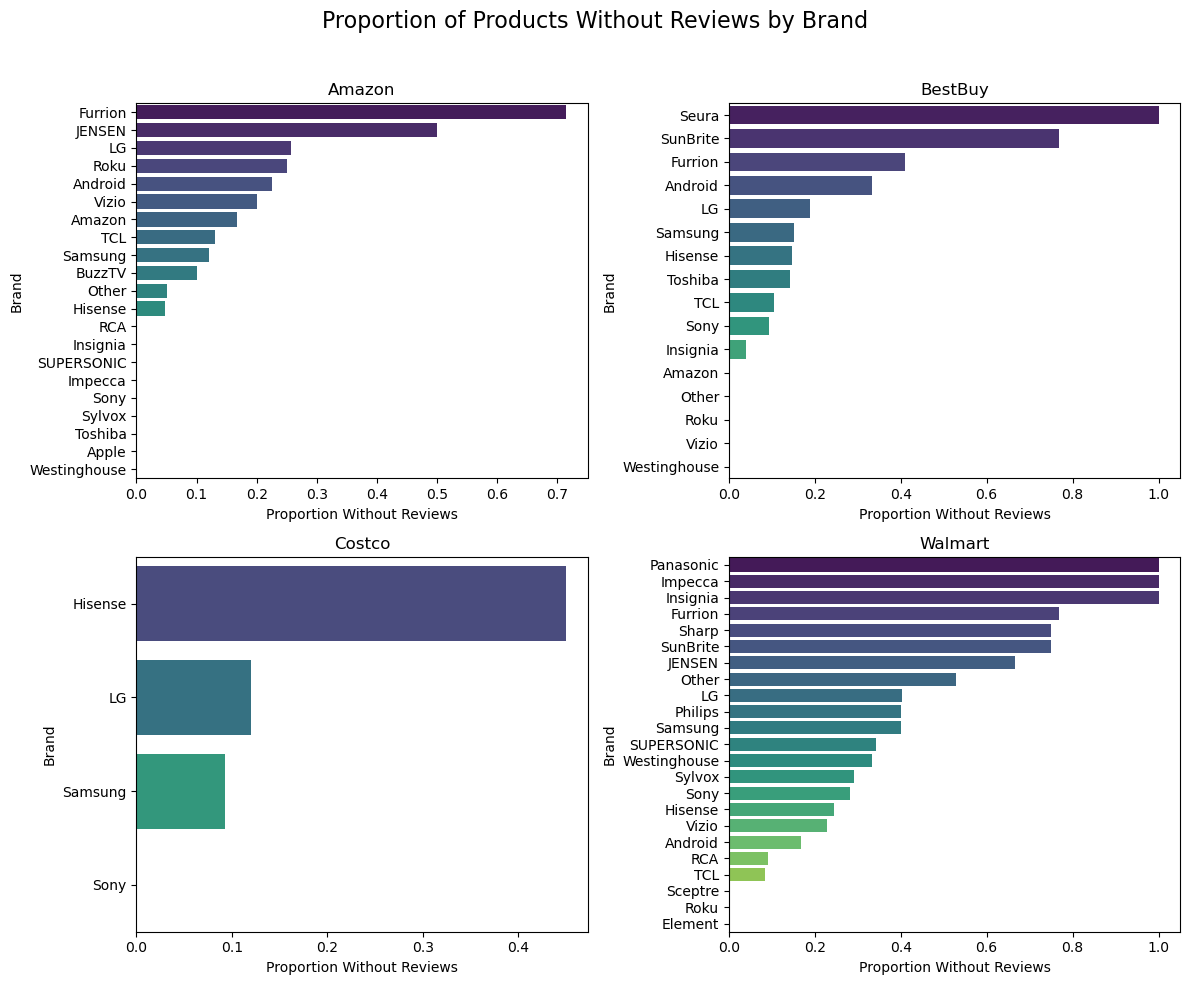

In [44]:
# List of common TV brands
common_brands = [
    'Samsung', 'LG', 'Sony', 'Panasonic', 'Philips', 'Toshiba',
    'Sharp', 'Vizio', 'TCL', 'Hisense', 'Insignia', 'Sceptre',
    'Skyworth', 'Element', 'Westinghouse', 'RCA', 'Impecca', 'Apple', 'Roku', 'Sylvox', 'BuzzTV', 'Android', 'Amazon', 'Seura',
    'SUPERSONIC', 'Furrion', 'SunBrite', 'JENSEN'
]

# Define a function to accurately extract the brand from the 'Product Name' column using the list of common brands
def extract_brand(product_name):
    if pd.isnull(product_name):
        return None
    for brand in common_brands:
        if brand.lower() in product_name.lower():
            return brand
    return 'Other'

# Define a function to create a subplot for the presence of reviews for different brands
def subplot_brand_reviews(ax, data, dataset_name):
    if 'Brand' not in data.columns:
        data['Brand'] = data['Product Name'].apply(extract_brand)
    
    brand_reviews = data.groupby('Brand').apply(lambda x: (x['Review Mark'] == 0).mean()).reset_index(name='No Reviews Proportion')
    brand_reviews = brand_reviews.sort_values(by='No Reviews Proportion', ascending=False)
    
    sns.barplot(x='No Reviews Proportion', y='Brand', data=brand_reviews, palette='viridis', ax=ax)
    ax.set_title(dataset_name, fontsize=12)
    ax.set_xlabel('Proportion Without Reviews', fontsize=10)
    ax.set_ylabel('Brand', fontsize=10)

# Extract brand information using the list of common brands for all datasets and re-visualize the presence of reviews for different brands
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Proportion of Products Without Reviews by Brand', fontsize=16)

# Visualize the presence of reviews for different brands for all datasets in the grid with accurate brand extraction
for (name, data), ax in zip(datasets_dict.items(), axes.flatten()):
    data['Brand'] = data['Product Name'].apply(extract_brand)
    subplot_brand_reviews(ax, data, name)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

In [53]:
for data in datasets_dict.values():
    print(data['Price'].isnull().sum())

53
0
1
17


In [ ]:
for name, data in datasets_dict.items():
    data.dropna(subset=['Price'], inplace=True)

In [51]:
amazon_data.to_csv('amazon_data_cleaned.csv', index=None)
bestbuy_data.to_csv('bestbuy_data_cleaned.csv', index=None)
costco_data.to_csv('costco_data_cleaned.csv', index=None)
walmart_data.to_csv('walmart_data_cleaned.csv', index=None)